# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2


[2018-01-22 23:10:02,350] Making new env: CartPole-v1


Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [4]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [5]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [6]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [7]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

C:\Users\ndrs\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [8]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [9]:
# Now train with experiences
saver = tf.train.Saver()        
rewards_list = []
with tf.Session(config=tf.ConfigProto(log_device_placement=True,allow_soft_placement=False)) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            #env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 30.0 Training loss: 1.1286 Explore P: 0.9970
Episode: 2 Total reward: 13.0 Training loss: 1.0096 Explore P: 0.9958
Episode: 3 Total reward: 10.0 Training loss: 1.2501 Explore P: 0.9948
Episode: 4 Total reward: 16.0 Training loss: 1.0589 Explore P: 0.9932
Episode: 5 Total reward: 14.0 Training loss: 1.0689 Explore P: 0.9918
Episode: 6 Total reward: 18.0 Training loss: 1.0276 Explore P: 0.9901
Episode: 7 Total reward: 28.0 Training loss: 0.9857 Explore P: 0.9873
Episode: 8 Total reward: 18.0 Training loss: 1.2948 Explore P: 0.9856
Episode: 9 Total reward: 13.0 Training loss: 1.3132 Explore P: 0.9843
Episode: 10 Total reward: 21.0 Training loss: 1.6397 Explore P: 0.9822
Episode: 11 Total reward: 15.0 Training loss: 1.2244 Explore P: 0.9808
Episode: 12 Total reward: 12.0 Training loss: 1.7054 Explore P: 0.9796
Episode: 13 Total reward: 16.0 Training loss: 2.0685 Explore P: 0.9781
Episode: 14 Total reward: 17.0 Training loss: 2.0035 Explore P: 0.9764
Episode: 15 Tot

Episode: 118 Total reward: 20.0 Training loss: 5.3182 Explore P: 0.7880
Episode: 119 Total reward: 14.0 Training loss: 255.8947 Explore P: 0.7869
Episode: 120 Total reward: 22.0 Training loss: 266.1230 Explore P: 0.7852
Episode: 121 Total reward: 28.0 Training loss: 134.7473 Explore P: 0.7830
Episode: 122 Total reward: 10.0 Training loss: 150.0340 Explore P: 0.7822
Episode: 123 Total reward: 26.0 Training loss: 128.4311 Explore P: 0.7802
Episode: 124 Total reward: 22.0 Training loss: 2.8951 Explore P: 0.7785
Episode: 125 Total reward: 12.0 Training loss: 127.4618 Explore P: 0.7776
Episode: 126 Total reward: 11.0 Training loss: 7.5563 Explore P: 0.7768
Episode: 127 Total reward: 25.0 Training loss: 6.5102 Explore P: 0.7749
Episode: 128 Total reward: 12.0 Training loss: 231.6736 Explore P: 0.7740
Episode: 129 Total reward: 15.0 Training loss: 228.6983 Explore P: 0.7728
Episode: 130 Total reward: 23.0 Training loss: 125.5233 Explore P: 0.7711
Episode: 131 Total reward: 20.0 Training loss:

Episode: 231 Total reward: 18.0 Training loss: 2.1983 Explore P: 0.6561
Episode: 232 Total reward: 41.0 Training loss: 1.7673 Explore P: 0.6535
Episode: 233 Total reward: 8.0 Training loss: 38.8777 Explore P: 0.6530
Episode: 234 Total reward: 78.0 Training loss: 2.7243 Explore P: 0.6480
Episode: 235 Total reward: 16.0 Training loss: 4.5666 Explore P: 0.6470
Episode: 236 Total reward: 39.0 Training loss: 3.2659 Explore P: 0.6445
Episode: 237 Total reward: 31.0 Training loss: 3.8872 Explore P: 0.6425
Episode: 238 Total reward: 42.0 Training loss: 3.1563 Explore P: 0.6399
Episode: 239 Total reward: 11.0 Training loss: 14.5596 Explore P: 0.6392
Episode: 240 Total reward: 44.0 Training loss: 3.2032 Explore P: 0.6364
Episode: 241 Total reward: 51.0 Training loss: 23.9439 Explore P: 0.6332
Episode: 242 Total reward: 30.0 Training loss: 2.6330 Explore P: 0.6314
Episode: 243 Total reward: 28.0 Training loss: 14.7034 Explore P: 0.6296
Episode: 244 Total reward: 77.0 Training loss: 18.6460 Explor

Episode: 345 Total reward: 60.0 Training loss: 41.0327 Explore P: 0.3406
Episode: 346 Total reward: 46.0 Training loss: 5.8741 Explore P: 0.3391
Episode: 347 Total reward: 71.0 Training loss: 62.0478 Explore P: 0.3368
Episode: 348 Total reward: 34.0 Training loss: 8.0283 Explore P: 0.3357
Episode: 349 Total reward: 98.0 Training loss: 9.3268 Explore P: 0.3325
Episode: 350 Total reward: 58.0 Training loss: 344.5454 Explore P: 0.3306
Episode: 351 Total reward: 35.0 Training loss: 200.7118 Explore P: 0.3295
Episode: 352 Total reward: 98.0 Training loss: 15.4805 Explore P: 0.3264
Episode: 353 Total reward: 60.0 Training loss: 455.3881 Explore P: 0.3245
Episode: 354 Total reward: 69.0 Training loss: 11.0209 Explore P: 0.3223
Episode: 355 Total reward: 95.0 Training loss: 196.2600 Explore P: 0.3194
Episode: 356 Total reward: 143.0 Training loss: 5.1093 Explore P: 0.3150
Episode: 357 Total reward: 71.0 Training loss: 3.8781 Explore P: 0.3128
Episode: 358 Total reward: 145.0 Training loss: 8.3

Episode: 466 Total reward: 81.0 Training loss: 1.2598 Explore P: 0.1043
Episode: 467 Total reward: 58.0 Training loss: 1.4058 Explore P: 0.1038
Episode: 468 Total reward: 85.0 Training loss: 1.2084 Explore P: 0.1030
Episode: 469 Total reward: 81.0 Training loss: 0.5251 Explore P: 0.1022
Episode: 470 Total reward: 77.0 Training loss: 1.2828 Explore P: 0.1015
Episode: 471 Total reward: 69.0 Training loss: 1.2773 Explore P: 0.1009
Episode: 472 Total reward: 75.0 Training loss: 1.5038 Explore P: 0.1002
Episode: 473 Total reward: 85.0 Training loss: 6.9452 Explore P: 0.0994
Episode: 474 Total reward: 77.0 Training loss: 1.2311 Explore P: 0.0987
Episode: 475 Total reward: 88.0 Training loss: 1.0635 Explore P: 0.0980
Episode: 476 Total reward: 78.0 Training loss: 1.7466 Explore P: 0.0973
Episode: 477 Total reward: 81.0 Training loss: 0.6668 Explore P: 0.0966
Episode: 478 Total reward: 90.0 Training loss: 0.9868 Explore P: 0.0958
Episode: 479 Total reward: 128.0 Training loss: 1.4433 Explore P

Episode: 688 Total reward: 99.0 Training loss: 0.3707 Explore P: 0.0150
Episode: 691 Total reward: 36.0 Training loss: 0.5906 Explore P: 0.0148
Episode: 694 Total reward: 99.0 Training loss: 0.2831 Explore P: 0.0146
Episode: 697 Total reward: 99.0 Training loss: 0.1948 Explore P: 0.0144
Episode: 700 Total reward: 65.0 Training loss: 0.3692 Explore P: 0.0142
Episode: 703 Total reward: 99.0 Training loss: 0.2996 Explore P: 0.0140
Episode: 706 Total reward: 99.0 Training loss: 0.3969 Explore P: 0.0138
Episode: 709 Total reward: 99.0 Training loss: 0.1578 Explore P: 0.0136
Episode: 712 Total reward: 64.0 Training loss: 0.3009 Explore P: 0.0134
Episode: 715 Total reward: 99.0 Training loss: 0.3808 Explore P: 0.0133
Episode: 718 Total reward: 99.0 Training loss: 0.2464 Explore P: 0.0131
Episode: 721 Total reward: 99.0 Training loss: 0.2778 Explore P: 0.0129
Episode: 724 Total reward: 99.0 Training loss: 0.1696 Explore P: 0.0128
Episode: 727 Total reward: 99.0 Training loss: 0.4367 Explore P:

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

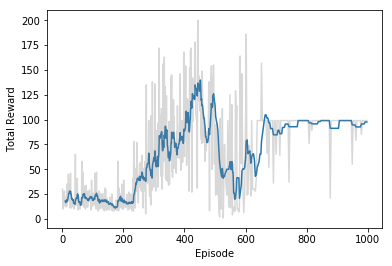

In [11]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.